# Clasificación de sentimientos con aprendizaje de pocos ejemplos (Few-shot Learning)

En este notebook probaé prompting con 0-shot, 1-shot y 5-shot usando openAI

In [31]:
import os
import openai
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

Usaré un conjunto simple con frases cortas etiquetas como "positivo" o "negativo"

In [33]:
examples = [
    ("I love this movie, it's fantastic!", "positivo"),
    ("This is the worst thing I've ever seen.", "negativo"),
    ("Absolutely amazing performance!", "positivo"),
    ("Terrible. I regret watching this.", "negativo"),
    ("I'm very happy with the result.", "positivo"),
    ("It's not good at all.", "negativo"),
    ("I enjoyed every minute of it.", "positivo"),
    ("I hate how this ended.", "negativo"),
]

# Dividimos en 5 ejemplos para few-shot y el resto como test
few_shot_examples = examples[:5]
test_data = examples[5:]

Función para construir prompts

In [34]:
def build_prompt(task_instruction, examples, new_input):
    """
    Construye un prompt con la instrucción, ejemplos (shots) y nueva entrada.
    """
    prompt = task_instruction + "\n\n"
    for ex, label in examples:
        prompt += f"Entrada: {ex}\nSentimiento: {label}\n\n"
    prompt += f"Entrada: {new_input}\nSentimiento:"
    return prompt

Función para llamar a OpenAI

In [35]:
def classify_sentiment(prompt):
    """
    Llamamos a la API de OpenAI para completar el prompt y devolver la respuesta
    """
    client = openai.OpenAI()

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    output = response.choices[0].message.content
    return output.strip().lower()


Prueba de diferentes configuraciones: 0-shot, 1-shot, 5-shot

In [36]:
shots_to_test = {
    "0-shot": [],
    "1-shot": few_shot_examples[:1],
    "5-shot": few_shot_examples[:5],
}

results = []
task_instruction = "Clasifica el sentimiento de la siguiente oración como 'positivo' o 'negativo'."

for shot_name, shots in shots_to_test.items():
    print(f"\nEvaluando configuración: {shot_name}\n")
    y_true = []
    y_pred = []
    for text, label in tqdm(test_data):
        prompt = build_prompt(task_instruction, shots, text)
        pred = classify_sentiment(prompt)
        y_true.append(label)
        y_pred.append(pred)
        print(f"\nTexto: {text}\nReal: {label} | Predicho: {pred}")
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label="positivo")
    results.append({"shots": shot_name, "accuracy": acc, "f1": f1})



Evaluando configuración: 0-shot



 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]


Texto: It's not good at all.
Real: negativo | Predicho: negativo


 67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]


Texto: I enjoyed every minute of it.
Real: positivo | Predicho: positivo


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Texto: I hate how this ended.
Real: negativo | Predicho: negativo

Evaluando configuración: 1-shot



 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]


Texto: It's not good at all.
Real: negativo | Predicho: negativo


 67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]


Texto: I enjoyed every minute of it.
Real: positivo | Predicho: positivo


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]



Texto: I hate how this ended.
Real: negativo | Predicho: negativo

Evaluando configuración: 5-shot



 33%|███▎      | 1/3 [00:00<00:01,  1.76it/s]


Texto: It's not good at all.
Real: negativo | Predicho: negativo


 67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]


Texto: I enjoyed every minute of it.
Real: positivo | Predicho: positivo


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Texto: I hate how this ended.
Real: negativo | Predicho: negativo



Resumen de resultados:

    shots  accuracy   f1
0  0-shot       1.0  1.0
1  1-shot       1.0  1.0
2  5-shot       1.0  1.0


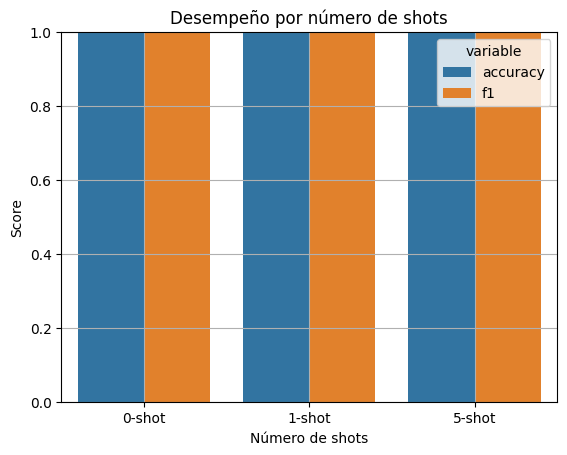

In [37]:
results_df = pd.DataFrame(results)
print("\nResumen de resultados:\n")
print(results_df)

sns.barplot(data=results_df.melt(id_vars="shots"), x="shots", y="value", hue="variable")
plt.title("Desempeño por número de shots")
plt.ylabel("Score")
plt.xlabel("Número de shots")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
